# Facies classification using Machine Learning #
## LA Team Submission ## 
### _[Lukas Mosser](https://at.linkedin.com/in/lukas-mosser-9948b32b/en), [Alfredo De la Fuente](https://pe.linkedin.com/in/alfredodelafuenteb)_ ####

In this python notebook we explore many different machine learning algorithms to outperform the prediction model proposed in the [prediction facies from wel logs challenge](https://github.com/seg/2016-ml-contest). Particulary, this is a classification problem that belongs to the area of supervised learning. Our approach involves a series of well-known machine learning and statistical algorithms to minimize the defined prediction error functions.

We will organize our present work in the following areas of analysis:
- *Problem Modeling*
- *Data Preprocessing* 
- *Data Analysis*
- *Results*


## Problem Modeling
----

The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a classifier to predict facies types. 

This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8


## Data Preprocessing
---

Let's import all the libraries that will be particularly needed for the analysis.

**IMPORTANT**: We need to install the [*xgboost*](http://xgboost.readthedocs.io/en/latest/python/python_intro.html) package to run this notebook ( %sh pip install xgboost ) 

In [3]:
import xgboost as xgb
print xgb.__version__

0.6


In [4]:
%matplotlib inline
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from pandas import set_option
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors
from sklearn import preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cross_validation import KFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from classification_utilities import display_cm, display_adj_cm

/home/alfredo/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/alfredo/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


We load the training data to start the exploration stage.

In [5]:
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = '../facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


We declare the fields "Formation" and "Well Name" as categorical variables and then map them to integer values.

In [6]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
Facies       4149 non-null int64
Formation    4149 non-null category
Well Name    4149 non-null category
Depth        4149 non-null float64
GR           4149 non-null float64
ILD_log10    4149 non-null float64
DeltaPHI     4149 non-null float64
PHIND        4149 non-null float64
PE           3232 non-null float64
NM_M         4149 non-null int64
RELPOS       4149 non-null float64
dtypes: category(2), float64(7), int64(2)
memory usage: 300.1 KB


*Observation*

We could remove the NaN values from the PE variable for further analysis, going from 4149 total values to just 3232 valid values for PE, which has 3232. However, because we will be using XGBoost Algorithm that handles missing data, this won't be necessary.

In [8]:
#PE_mask = training_data['PE'].notnull().values
#training_data = training_data[PE_mask]

We must realize the classification problem is **highly imbalanced**, therefore making it more challenging to approach.

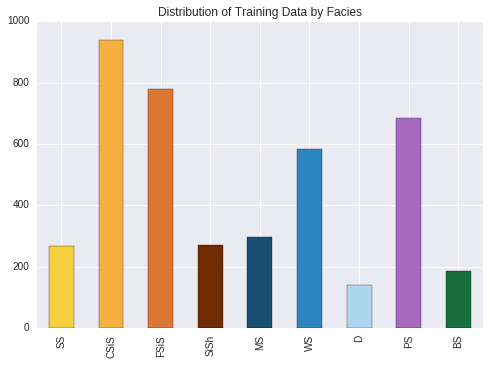

In [7]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72',
                 '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

facies_counts = training_data['Facies'].value_counts().sort_index()
facies_counts.index = facies_labels
facies_counts.plot(kind='bar',color=facies_colors,title='Distribution of Training Data by Facies')

We produce correlation plot to observe relationship between variables. The target variable '**Facies**' is highly correlated to '**NM_M**', '**PE**' and '**ILD_log10**'. 

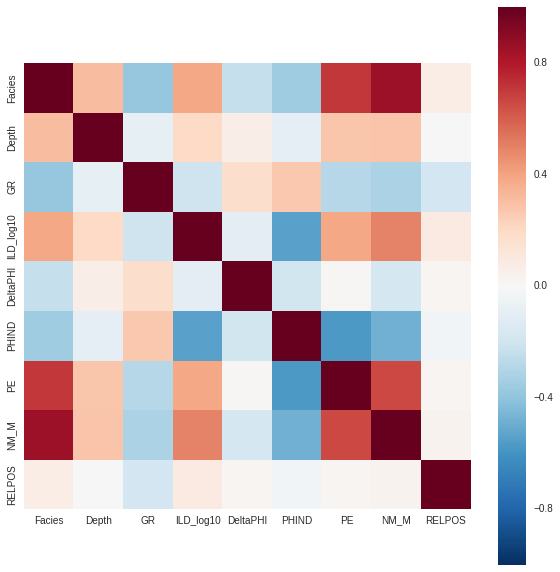

In [8]:
plt.figure(figsize=(10, 10))
sns.heatmap(training_data.corr(), vmax=1.0, square=True)

In [9]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


## Data Analysis
---
XGboost will be our weapon of choice. XGBoost (or Extreme Gradient Boosting) is a sophisticated algorithm that corresponds to an advanced implementation of gradient boosting algorithm. Despite it's complexity, it is fairly easy to use and very powerful to deal with many different types of irregularities in data. It has been no surprise then, that is has been extensively applied in many machine learning competitions to obtain very promising results.

For the above reasons, to implement the XGBoost algorithm for our regression problem, we will use the above preprocessed data without modifications.

In [11]:
X_train = training_data.drop(['Facies', 'Well Name','Formation','Depth'], axis = 1 ) 
Y_train = training_data['Facies' ] - 1
dtrain = xgb.DMatrix(X_train, Y_train)
type(Y_train)

pandas.core.series.Series

In order to evaluate our classification model accurary we will use the our following defined metrics, based on the confusion matrix once the classification is performed. The first metric only considers misclassification error and the second one takes into account the fact that facies could be misclassified if they belong to a same group with similar geological characteristics.

In [13]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

Although XGBoost is a very straightforward algorithm to implement, it's difficulty arises in dealing with a big number of hyperparameters. For that reason, we need to develop routines to tune this parameters to optimize the algorithm performance on the data prediction.

We will use a Cross-Validation approach to improve our model by tuning parameters at each step. There are three types of parameters to consider:

- General Parameters: Guide the overall functioning
- Booster Parameters: Guide the individual booster (tree/regression) at each step
- Learning Task Parameters: Guide the optimization performed

We must realize that our training data is quite reduced, therefore to evaluate our model generalization 


Cross Validation Training Report Summary
     test-merror-mean  test-merror-std  train-merror-mean  train-merror-std
495          0.300542         0.027071           0.119600          0.002584
496          0.300541         0.026525           0.119467          0.002573
497          0.300301         0.026946           0.119360          0.002711
498          0.300302         0.026554           0.119279          0.002586
499          0.300062         0.026801           0.119038          0.002504

Model Report
-Accuracy: 0.872258
-Adjacent Accuracy: 0.971077

Confusion Matrix
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   212    50     6                                       268
     CSiS     7   869    63                 1                     940
     FSiS          99   679                 1           1         780
     SiSh           1     1   242          18           9         271
       MS           2     3     9   222    36     1    23    

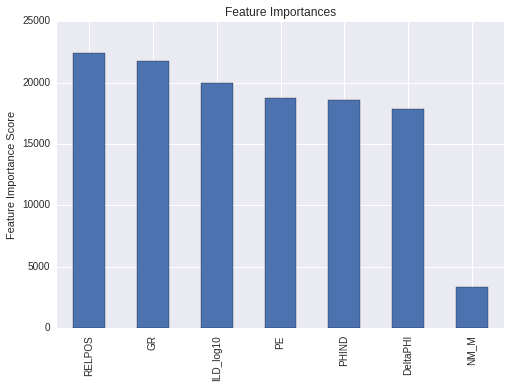

In [15]:
# Cross Validation parameters
cv_folds = 10
rounds = 100 

# Proposed Initial Model
xgb1 = xgb.XGBClassifier( learning_rate =0.01, n_estimators=500, max_depth=6,
                          min_child_weight=1, gamma=0, subsample=0.8,
                          colsample_bytree=0.8, objective='multi:softmax',
                          nthread=4, scale_pos_weight=1, seed=27)

xgb_param_1 = xgb1.get_xgb_params()
xgb_param_1['num_class'] = 9

# Perform cross-validation
cvresult = xgb.cv(xgb_param_1, dtrain, num_boost_round=xgb_param_1['n_estimators'], 
                  stratified = True, nfold=cv_folds, metrics='merror', early_stopping_rounds=rounds)

print "\nCross Validation Training Report Summary"
print cvresult.tail()

xgb1.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
xgb1.fit(X_train, Y_train,eval_metric='merror')

#Predict training set:
predictions = xgb1.predict(X_train)
        
#Print model report

# Confusion Matrix
conf = confusion_matrix(Y_train, predictions )

# Print Results
print "\nModel Report"
print "-Accuracy: %.6f" % ( accuracy(conf) )
print "-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) )

print "\nConfusion Matrix"
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

# Print Feature Importance
feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

By performing cross-validation routines we can use the produced results to measure how well the model generalizes and at the same time tune the hyperparameters. In this case, we will explore how the results look like if we vary the learning rate.

In [49]:
print("Parameter optimization")
grid_search1 = GridSearchCV(xgb1,{'learning_rate':[0.001,0.01,0.05] , 'n_estimators':[100,200,500]},
                                   scoring='accuracy' , n_jobs = 4)
grid_search1.fit(X_train,Y_train)
print("Best Set of Parameters")
grid_search1.grid_scores_, grid_search1.best_params_, grid_search1.best_score_

Parameter optimization
Best Set of Parameters


([mean: 0.54567, std: 0.02950, params: {'n_estimators': 100, 'learning_rate': 0.001},
  mean: 0.54857, std: 0.03048, params: {'n_estimators': 200, 'learning_rate': 0.001},
  mean: 0.54929, std: 0.02804, params: {'n_estimators': 500, 'learning_rate': 0.001},
  mean: 0.54543, std: 0.03025, params: {'n_estimators': 100, 'learning_rate': 0.01},
  mean: 0.54616, std: 0.02601, params: {'n_estimators': 200, 'learning_rate': 0.01},
  mean: 0.54471, std: 0.02943, params: {'n_estimators': 500, 'learning_rate': 0.01},
  mean: 0.54664, std: 0.03185, params: {'n_estimators': 100, 'learning_rate': 0.05},
  mean: 0.53748, std: 0.03340, params: {'n_estimators': 200, 'learning_rate': 0.05},
  mean: 0.53603, std: 0.02934, params: {'n_estimators': 500, 'learning_rate': 0.05}],
 {'learning_rate': 0.001, 'n_estimators': 500},
 0.54928898529766212)


Cross Validation Training Report Summary
     test-merror-mean  test-merror-std  train-merror-mean  train-merror-std
200          0.347343         0.026566           0.253086          0.005239
201          0.346135         0.025265           0.252603          0.004960
202          0.346377         0.025681           0.252576          0.004955
203          0.345894         0.025167           0.252362          0.005330
204          0.345169         0.025275           0.252496          0.005114

Model Report
-Accuracy: 0.872258
-Adjacent Accuracy: 0.971077

Confusion Matrix
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   212    50     6                                       268
     CSiS     7   869    63                 1                     940
     FSiS          99   679                 1           1         780
     SiSh           1     1   242          18           9         271
       MS           2     3     9   222    36     1    23    

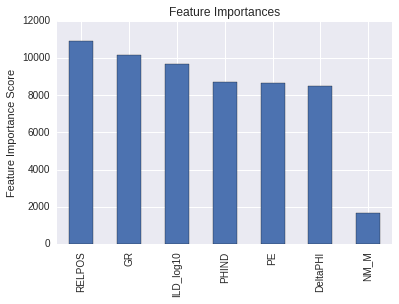

In [50]:
# Cross Validation parameters
cv_folds = 10
rounds = 100

# Proposed Initial Model
xgb2 = xgb.XGBClassifier( learning_rate =0.001, n_estimators=500, max_depth=6,
                          min_child_weight=1, gamma=0, subsample=0.8,
                          colsample_bytree=0.8, objective='multi:softmax',
                          nthread=4, scale_pos_weight=1, seed=27)

xgb_param_2 = xgb2.get_xgb_params()
xgb_param_2['num_class'] = 9

# Perform cross-validation
cvresult = xgb.cv(xgb_param_2, dtrain, num_boost_round=xgb_param_2['n_estimators'], 
                  nfold=cv_folds, metrics='merror', early_stopping_rounds=rounds)

print "\nCross Validation Training Report Summary"
print cvresult.tail()

xgb2.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
xgb2.fit(X_train, Y_train,eval_metric='merror')

#Predict training set:
predictions = xgb2.predict(X_train)
        
#Print model report

# Confusion Matrix
conf = confusion_matrix(Y_train, predictions )

# Print Results
print "\nModel Report"
print "-Accuracy: %.6f" % ( accuracy(conf) )
print "-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) )

# Confusion Matrix
print "\nConfusion Matrix"
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

# Print Feature Importance
feat_imp = pd.Series(xgb2.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [13]:
print("Parameter optimization")
grid_search1 = GridSearchCV(xgb2,{'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] },
                                   scoring='accuracy' , n_jobs = 4)
grid_search1.fit(X_train,Y_train)
print("Best Set of Parameters")
grid_search1.grid_scores_, grid_search1.best_params_, grid_search1.best_score_

Parameter optimization
Best Set of Parameters


([mean: 0.54857, std: 0.03049, params: {'reg_alpha': 1e-05},
  mean: 0.54857, std: 0.02998, params: {'reg_alpha': 0.01},
  mean: 0.54953, std: 0.02981, params: {'reg_alpha': 0.1},
  mean: 0.55098, std: 0.03085, params: {'reg_alpha': 1},
  mean: 0.42926, std: 0.02015, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.55097613882863339)

In [16]:
#Final Model 
cv_folds = 10
rounds = 100
xgb_final = xgb.XGBClassifier( learning_rate =0.001, n_estimators=500, max_depth=6,
                               min_child_weight=1, gamma=0, subsample=0.8, reg_alpha = 1,
                               colsample_bytree=0.8, objective='multi:softmax',
                               nthread=4, scale_pos_weight=1, seed=27)

xgb_param_final = xgb_final.get_xgb_params()
xgb_param_final['num_class'] = 9

# Perform cross-validation
cvresult = xgb.cv(xgb_param_final, dtrain, num_boost_round=xgb_param_final['n_estimators'], 
                  nfold=cv_folds, metrics='merror', early_stopping_rounds=rounds)

print "\nCross Validation Training Report Summary"
print cvresult.tail()

xgb_final.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
xgb_final.fit(X_train, Y_train,eval_metric='merror')

#Predict training set:
predictions = xgb_final.predict(X_train)
        
#Print model report

# Confusion Matrix
print "\nConfusion Matrix"
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

# Print Results
print "\nModel Report"
print "-Accuracy: %.6f" % ( accuracy(conf) )
print "-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) )


Cross Validation Training Report Summary
    test-merror-mean  test-merror-std  train-merror-mean  train-merror-std
90          0.356763         0.022737           0.279576          0.004607
91          0.355555         0.023686           0.279737          0.004639
92          0.355797         0.021767           0.279227          0.004456
93          0.355314         0.022360           0.279173          0.004442
94          0.354831         0.021617           0.279173          0.004450

Confusion Matrix
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   212    50     6                                       268
     CSiS     7   869    63                 1                     940
     FSiS          99   679                 1           1         780
     SiSh           1     1   242          18           9         271
       MS           2     3     9   222    36     1    23         296
       WS     1           2    20    12   489     4    53   

## Results
---

We will see the performance of the model by taking the average accuracy and adjacency accuracy in Leaving Out One Well Cross Validation routine.

In [14]:
# Import data
filename = '../facies_vectors.csv'
data = pd.read_csv(filename)

data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')

# Leave out one well for prediction
well_names = data['Well Name'].unique()
f1=[]
for i in range(len(well_names)):
    
    # Split data
    X_train = data.drop(['Facies', 'Formation','Depth'], axis = 1 ) 
    Y_train = data['Facies' ] - 1
    
    train_X = X_train[X_train['Well Name'] != well_names[i] ]
    train_Y = Y_train[X_train['Well Name'] != well_names[i] ]
    test_X  = X_train[X_train['Well Name'] == well_names[i] ]
    test_Y  = Y_train[X_train['Well Name'] == well_names[i] ]

    train_X = train_X.drop(['Well Name'], axis = 1 ) 
    test_X = test_X.drop(['Well Name'], axis = 1 )

    # Model
    model_final = xgb.XGBClassifier( learning_rate =0.001, n_estimators=500, max_depth=6,
                                   min_child_weight=1, gamma=0, subsample=0.8, reg_alpha = 10,
                                   colsample_bytree=0.8, objective='multi:softmax',
                                   nthread=4, scale_pos_weight=1, seed=27)

    #Fit the algorithm on the data
    model_final.fit( train_X , train_Y , eval_metric = 'merror' )

    # model_final = RandomForestClassifier(n_estimators=1000) # RANDOM FORREST
    #model_final.fit(train_X, train_Y)

    #Predict training set:
    predictions = model_final.predict(test_X)

    #Print model report
    print "\n------------------------------------------------------"
    print "Leaving out well " + well_names[i]
    # Confusion Matrix
    conf = confusion_matrix( test_Y, predictions, labels = np.arange(9) )
    # Print Results
    print "\nModel Report"
    print "-Accuracy: %.6f" % ( accuracy(conf) )
    print "-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) )
    print "-F1 Score: %.6f" % ( f1_score ( test_Y , predictions , labels = np.arange(9), average = 'weighted' ) )
    f1.append(f1_score ( test_Y , predictions , labels = np.arange(9), average = 'weighted' ))
    facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                     'WS', 'D','PS', 'BS']
    print "\nConfusion Matrix Results"
    from classification_utilities import display_cm, display_adj_cm
    display_cm(conf, facies_labels,display_metrics=True, hide_zeros=True)
    
print "\n------------------------------------------------------"
print "Final Results"
print "-Average F1 Score: %6f" % (sum(f1)/(1.0*len(f1)))


------------------------------------------------------
Leaving out well SHRIMPLIN

Model Report
-Accuracy: 0.577495
-Adjacent Accuracy: 0.951168
-F1 Score: 0.547461

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS    14    85    19                                       118
     FSiS     2    54    67                                       123
     SiSh                      12     1     2           2     1    18
       MS                 1     6          49           7          63
       WS                       3          43     2    11     4    63
        D                                               5           5
       PS                       1           7          56     5    69
       BS                                               3     9    12

Precision  0.00  0.61  0.77  0.55  0.00  0.43  0.00  0.67  0.47  0.54
   Recall  0.00  0.72  0.54

/home/alfredo/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Leaving out well ALEXANDER D

Model Report
-Accuracy: 0.637339
-Adjacent Accuracy: 0.916309
-F1 Score: 0.613383

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS          96    21                                       117
     FSiS          30    61                                        91
     SiSh                      40           1     2     1          44
       MS                       4     2    11           9          26
       WS                      14     1    22     3    29          69
        D                                   1     6     9          16
       PS                       9          12     7    70          98
       BS                       3                       2           5

Precision  0.00  0.76  0.74  0.57  0.67  0.47  0.33  0.58  0.00  0.63
   Recall  0.00  0.82  0.

/home/alfredo/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



------------------------------------------------------
Leaving out well SHANKLE

Model Report
-Accuracy: 0.527840
-Adjacent Accuracy: 0.966592
-F1 Score: 0.494047

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     4    82     3                                        89
     CSiS     8    67    14                                        89
     FSiS          40    77                                       117
     SiSh                       4           1           2           7
       MS                      14           4           1          19
       WS                       6     2    50          13          71
        D     2                             1     5     9          17
       PS                                  10          30          40
       BS                                                           0

Precision  0.29  0.35  0.82  0.17  0.00  0.76  1.00  0.55  0.00  0.55
   Recall  0.04  0.75  0.66  

### We obtain an Average F1 Score from fitting the model to a leaving out one well **0.528226**

We import the testing data and apply our trained model to make a prediction.

In [108]:
# Load test data
test_data = pd.read_csv('validation_data_nofacies.csv')
test_data['Well Name'] = test_data['Well Name'].astype('category')
X_test = test_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
# Predict facies of unclassified data
Y_predicted = xgb_final.predict(X_test)
test_data['Facies'] = Y_predicted + 1
# Store the prediction
test_data.to_csv('Prediction.csv')